# dataloaders

> Bundle trn/val/test datasets together, and add helpful functionality for viewing data

In [ ]:
#| hide
#|default_exp dataloaders

In [1]:
#|hide
%load_ext autoreload
%autoreload 2

In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| export
from AIsaac.utils import *
import pandas as pd, numpy as np, fastcore.all as fc
import matplotlib.pyplot as plt,matplotlib as mpl
import random
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import default_collate
from operator import itemgetter

/home/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#|hide
import logging

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

set_seed(42)

In [5]:
#|export
@fc.delegates(DataLoader)
def get_dataloaders(train_dataset, valid_dataset, batch_size, **kwargs):
    return (DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs),
            DataLoader(valid_dataset, batch_size=batch_size*2, shuffle=False, **kwargs))

In [6]:
#| export
def collate_dataset_dict(dataset):
    get = itemgetter(*dataset.features)
    def _f(b): return get(default_collate(b))
    return _f

In [7]:
#| export
class DataLoaders():
    def __init__(self, train, valid,n_inp=1): fc.store_attr()
    
    @classmethod
    def from_dataset_dict(cls, dataset_dict, batch_size, **kwargs):
        f = collate_dataset_dict(dataset_dict['train'])
        return cls(*get_dataloaders(*dataset_dict.values(), batch_size=batch_size, collate_fn=f))

    @fc.delegates(get_grid)
    def show_batch(self, n=9, train_dataset=True, **kwargs):
        _dataset = getattr(self, 'train').dataset if train_dataset else getattr(self, 'valid').dataset
        batch = list(zip(*_dataset[random.sample(range(len(_dataset)),n)].values()))
        fig,axs = get_grid(n=n,**kwargs)
        for (image,label),ax in zip(batch,axs.flat):
            show_image(image,ax=ax,title=_dataset.features['label'].names[label])

In [8]:
#| export
def sample_dataset_dict(dataset, sample_sizes=(500,500)):
    for sample_size,name in zip(sample_sizes,dataset):
        sample_idxs = random.sample(range(len(dataset[name])),sample_size)
        dataset[name] = dataset[name].select(sample_idxs)
    return dataset

In [9]:
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

_dataset = load_dataset('fashion_mnist').with_transform(transformi)
_dataset = sample_dataset_dict(_dataset)
dls = DataLoaders.from_dataset_dict(_dataset, 64, num_workers=4)

100%|██████████| 2/2 [00:00<00:00, 364.98it/s]


In [16]:
_dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

In [12]:
dls.train.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

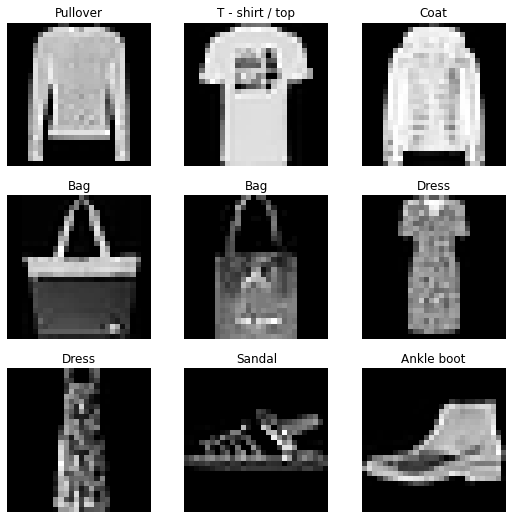

In [ ]:
dls.show_batch()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()